#Classification Binaire

Pour ce projet, nous avons choisi d'explorer le potentiel du Deep Learning face à un défi médical concret : le dépistage du cancer du sein via l'analyse d'images histopathologiques. Nous travaillons avec le dataset BreakHis, qui regroupe des prélèvements de tissus mammaires (bénins et malins) observés sous plusieurs grossissements. L'idée est de voir comment l'automatisation de l'analyse d'image peut devenir un véritable outil d'appui pour les pathologistes, notamment pour accélérer le diagnostic dans des contextes où le temps est compté.

Dans cette première étape de nos travaux, nous avons choisi de nous focaliser exclusivement sur la classification binaire. Notre but est de distinguer les tumeurs bénignes des tumeurs malignes avant d'envisager, par la suite, une analyse plus fine des sous-types.

## Librairies and Data Import


In [ ]:

import os
import re
import zipfile
import random
import shutil
import pathlib
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
import tensorflow as tf
from tensorflow.keras import layers, models, callbacks
from tensorflow.keras.applications import EfficientNetB0
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
from google.colab import drive

import cv2
from PIL import Image


In [ ]:
drive.mount('/content/drive')
zip_path = "/content/drive/MyDrive/breakhis.zip"

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall("/content/breakhis")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Classification (200*)

In [ ]:
root = pathlib.Path("/content/breakhis")
subset_path = pathlib.Path("/content/breakhis_200")
subset_path.mkdir(exist_ok=True)

# Parcours des fichiers et copie des images 200×
for img_path in root.rglob("*.png"):
    if "-200-" in str(img_path):
        dest = subset_path / img_path.name
        shutil.copy(img_path, dest)

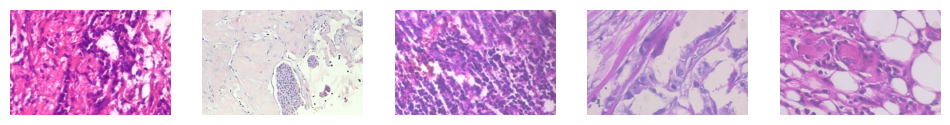

In [ ]:
sample_imgs = random.sample(list(subset_path.glob("*.png")), 5)

plt.figure(figsize=(12,6))
for i, img in enumerate(sample_imgs):
    plt.subplot(1,5,i+1)
    plt.imshow(mpimg.imread(img))
    plt.axis('off')
plt.show()


On choisit les images à 200× car ce niveau de grossissement offre un bon compromis entre détail et surface observée.

À 200×, les structures cellulaires et les tissus sont suffisamment visibles pour que le modèle puisse apprendre à différencier les tissus bénins et malins, sans que les images soient trop grandes ni trop lourdes à traiter.

Les autres grossissements (40×, 100×, 400×) montrent soit trop peu de détails (40×, 100×), soit trop de variations locales difficiles à généraliser (400×). Le 200× est donc souvent utilisé dans les études de classification BreakHis, car il permet d’obtenir de bons résultats de reconnaissance tout en gardant un temps de calcul raisonnable.

###Data Frame construction

On lit chaque nom d’image, on récupère le label, le sous-type, l’ID patient et la magnification, puis on met tout dans un DataFrame.

In [ ]:
def parse_info_fixed(filename):
    name = filename.name
    stem = name[:-4] if name.lower().endswith(".png") else name
    parts = stem.split("-")

    head = parts[0]
    label = "benign" if "_B_" in head else "malignant"
    subtype = head.split("_", 2)[-1]

    return {
        "path": str(filename),
        "label": label,
        "subtype": subtype,
        "patient_id": parts[2],
        "magnif": parts[3]
    }


In [ ]:
rows = [parse_info_fixed(p) for p in subset_path.glob("*.png")]
df_200 = pd.DataFrame(rows)
df_200.head()

,path,label,subtype,patient_id,magnif
0,/content/breakhis_200/SOB_M_DC-14-8168-200-006...,malignant,DC,8168,200
1,/content/breakhis_200/SOB_M_MC-14-18842D-200-0...,malignant,MC,18842D,200
2,/content/breakhis_200/SOB_M_DC-14-18650-200-02...,malignant,DC,18650,200
3,/content/breakhis_200/SOB_M_DC-14-12312-200-01...,malignant,DC,12312,200
4,/content/breakhis_200/SOB_B_F-14-14134-200-023...,benign,F,14134,200


In [ ]:
print(f"Nombre d'images (200×)       : {len(df_200)}")
print(f"Nombre de patients uniques   : {df_200['patient_id'].nunique()}")
print("\nRépartition des labels :")
print(df_200['label'].value_counts())
print("\nRépartition des sous-types :")
print(df_200['subtype'].value_counts())

Nombre d'images (200×)       : 2013
Nombre de patients uniques   : 81

Répartition des labels :
label
malignant    1390
benign        623
Name: count, dtype: int64

Répartition des sous-types :
subtype
DC    896
F     264
MC    196
LC    163
TA    140
PC    135
A     111
PT    108
Name: count, dtype: int64


Les statistiques affichées permettent de mieux comprendre la composition du dataset utilisé. Après filtrage, le sous-ensemble à 200× contient 2013 images issues de 81 patients différents, ce qui représente une base de données suffisamment large et variée pour entraîner un modèle de classification fiable.

On observe une forte majorité d’images malignes (1390) contre 623 bénignes, ce qui met en évidence un déséquilibre de classes. Ce déséquilibre est important à prendre en compte, car il peut influencer l’apprentissage du modèle : celui-ci pourrait avoir tendance à privilégier la classe majoritaire (maligne) et moins bien reconnaître les cas bénins. Pour pallier ce problème, l’utilisation de poids de classes permettra d’équilibrer la contribution de chaque type d’image lors de l’entraînement, assurant ainsi une meilleure performance globale et une détection plus juste des deux catégories.

### Split DataFrame

On sépare le dataset par patients pour créer trois ensembles : un pour l’entraînement, un pour la validation et un pour le test comme ça un même patient n’apparaît jamais dans plusieurs sets.

In [ ]:
def split_by_patient(df, train_frac=0.8, val_frac=0.1, seed=42):
    patients = np.array(sorted(df['patient_id'].unique()))
    rng = np.random.RandomState(seed)
    rng.shuffle(patients)

    G = len(patients)
    n_train = int(round(train_frac * G))
    n_val   = int(round(val_frac   * G))

    train_p = set(patients[:n_train])
    val_p   = set(patients[n_train:n_train+n_val])
    test_p  = set(patients[n_train+n_val:])

    df_train = df[df.patient_id.isin(train_p)].reset_index(drop=True)
    df_val   = df[df.patient_id.isin(val_p)].reset_index(drop=True)
    df_test  = df[df.patient_id.isin(test_p)].reset_index(drop=True)

    return df_train, df_val, df_test

In [ ]:
df_train, df_val, df_test = split_by_patient(df_200, train_frac=0.8, val_frac=0.1, seed=42)

print(f"Train: {len(df_train)} imgs / {df_train['patient_id'].nunique()} patients")
print(f"Val:   {len(df_val)} imgs / {df_val['patient_id'].nunique()} patients")
print(f"Test:  {len(df_test)} imgs / {df_test['patient_id'].nunique()} patients")


Train: 1582 imgs / 65 patients
Val:   195 imgs / 8 patients
Test:  236 imgs / 8 patients


###Tenser Flow

On normalise les images en les mettant toutes au format 224×224, et on applique le préprocessing d’EfficientNet pour qu’elles soient adaptées au modèl

In [ ]:
IMG_SIZE = 224
BATCH = 32

def decode_img(path):
    img = tf.io.read_file(path)
    img = tf.io.decode_png(img, channels=3)
    img = tf.image.resize(img, (IMG_SIZE, IMG_SIZE))
    return tf.keras.applications.efficientnet.preprocess_input(img)

On augmente les données : ce bloc applique des petites transformations aléatoires aux images (flip, rotation, zoom, translation, contraste).
Le but, c’est de créer des versions légèrement modifiées des images pour rendre le modèle plus robuste et éviter le surapprentissage.

In [ ]:
augment = tf.keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.08),
    layers.RandomZoom(0.12),
    layers.RandomTranslation(0.08, 0.08),
    layers.RandomContrast(0.1),
], name="augment_stronger")
label_to_int = {"benign": 0, "malignant": 1}


On transforme le DataFrame en un dataset TensorFlow où les images sont chargées, prétraitées et mises en batch pour que le modèle puisse s’entraîner dessus

In [ ]:
def make_ds(df, training=False):
    X = df["path"].values
    y = df["label"].map(label_to_int).astype("int32").values
    ds = tf.data.Dataset.from_tensor_slices((X, y))
    def _map(p, l):
        img = decode_img(p)
        if training: img = augment(img)
        return img, tf.one_hot(l, 2)
    ds = ds.map(_map, num_parallel_calls=tf.data.AUTOTUNE)
    if training: ds = ds.shuffle(4096, reshuffle_each_iteration=True)
    return ds.batch(BATCH).prefetch(tf.data.AUTOTUNE)

In [ ]:
train_ds = make_ds(df_train, training=True)
val_ds   = make_ds(df_val)
test_ds  = make_ds(df_test)

###Model Creation

On rééquilibre les deux classes : on donne plus de poids à la classe la moins représentée pour éviter que le modèle favorise la classe majoritaire.

In [ ]:
# Class weights
y_train_int = df_train["label"].map(label_to_int).values
cw = compute_class_weight(class_weight="balanced", classes=np.array([0, 1]), y=y_train_int)
class_weights = {0: float(cw[0]), 1: float(cw[1])}
print("class_weights:", class_weights)

class_weights: {0: 1.5788423153692615, 1: 0.7317298797409806}


Ici, nous avons construit notre modèle de classification d’images à partir de EfficientNetB0, un réseau de neurones préentraîné sur ImageNet.

Nous avons choisi de geler les couches de base (base.trainable = False) afin de conserver les poids déjà appris lors du préentraînement. Seules les dernières couches ont été modifiées pour adapter le modèle à notre tâche, c’est-à-dire la classification binaire entre les tissus bénins et malins. Concrètement, nous avons ajouté une couche de GlobalAveragePooling2D pour réduire les dimensions, une Dropout (0.25) pour éviter le surapprentissage, et une Dense avec une activation softmax pour prédire les deux classes.


In [ ]:

base = EfficientNetB0(include_top=False, weights="imagenet",
                      input_shape=(IMG_SIZE, IMG_SIZE, 3))
base.trainable = False

inp = layers.Input(shape=(IMG_SIZE, IMG_SIZE, 3))


x = base(inp)

x = layers.GlobalAveragePooling2D()(x)
x = layers.Dropout(0.25)(x)
out = layers.Dense(2, activation="softmax")(x)

model = models.Model(inp, out)


model.compile(
    optimizer="adam",
    loss="categorical_crossentropy",
    metrics=[
        "accuracy",
        tf.keras.metrics.Recall(name="recall"),                    # macro (toutes classes)
        tf.keras.metrics.Recall(class_id=1, name="recall_malignant")  # classe 1 = malignant
    ]
)

model.summary()

Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_9 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ efficientnetb0 (Functional)     │ (None, 7, 7, 1280)     │     4,049,571 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_3      │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 2)              │         2,562 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,052,133 (15.46 MB)

 Trainable params: 2,562 (10.01 KB)

 Non-trainable params: 4,049,571 (15.45 MB)

In [ ]:
def plot_history(history, title="Training curves"):
    import matplotlib.pyplot as plt
    H = history.history

    plt.figure(figsize=(15,4))

    # --- Accuracy ---
    plt.subplot(1,3,1)
    plt.plot(H.get("accuracy", []), label="train")
    plt.plot(H.get("val_accuracy", []), label="val")
    plt.title("Accuracy")
    plt.xlabel("epoch")
    plt.ylabel("acc")
    plt.legend()

    # --- Recall malignant ---
    plt.subplot(1,3,2)
    plt.plot(H.get("recall_malignant", []), label="train recall_malignant")
    plt.plot(H.get("val_recall_malignant", []), label="val recall_malignant")
    plt.title("Recall (malignant)")
    plt.xlabel("epoch")
    plt.ylabel("recall")
    plt.legend()

    # --- Loss ---
    plt.subplot(1,3,3)
    plt.plot(H.get("loss", []), label="train")
    plt.plot(H.get("val_loss", []), label="val")
    plt.title("Loss")
    plt.xlabel("epoch")
    plt.ylabel("loss")
    plt.legend()

    plt.suptitle(title)
    plt.tight_layout()
    plt.show()


### Training

on sauvegarde le modèle qui donne le meilleur recall sur les malignes, on arrête l’entraînement si ce recall n’améliore plus, et on réduit le learning rate quand la loss de validation stagne pour affiner l’apprentissage

In [ ]:
cbs = [
    callbacks.ModelCheckpoint(
        "best_200x.h5",
        monitor="val_recall_malignant",
        mode="max",
        save_best_only=True,
        verbose=1
    ),
    callbacks.EarlyStopping(
        monitor="val_recall_malignant",
        mode="max",
        patience=4,
        restore_best_weights=True,
        verbose=1
    ),
    callbacks.ReduceLROnPlateau(
        monitor="val_loss",
        factor=0.5,
        patience=2,
        min_lr=1e-6,
        verbose=1
    ),
]


In [ ]:
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=10,
    class_weight=class_weights,
    callbacks=cbs,
    verbose=1,
)


Epoch 1/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 261ms/step - accuracy: 0.6465 - loss: 0.6371 - recall: 0.6465 - recall_malignant: 0.6679
Epoch 1: val_recall_malignant improved from -inf to 0.84507, saving model to best_200x.h5


50/50 ━━━━━━━━━━━━━━━━━━━━ 81s 548ms/step - accuracy: 0.6477 - loss: 0.6358 - recall: 0.6477 - recall_malignant: 0.6689 - val_accuracy: 0.8769 - val_loss: 0.3806 - val_recall: 0.8769 - val_recall_malignant: 0.8451 - learning_rate: 0.0010
Epoch 2/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - accuracy: 0.7733 - loss: 0.4678 - recall: 0.7733 - recall_malignant: 0.7618
Epoch 2: val_recall_malignant improved from 0.84507 to 0.87324, saving model to best_200x.h5


50/50 ━━━━━━━━━━━━━━━━━━━━ 37s 106ms/step - accuracy: 0.7738 - loss: 0.4673 - recall: 0.7738 - recall_malignant: 0.7627 - val_accuracy: 0.9077 - val_loss: 0.3117 - val_recall: 0.9077 - val_recall_malignant: 0.8732 - learning_rate: 0.0010
Epoch 3/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - accuracy: 0.8335 - loss: 0.3840 - recall: 0.8335 - recall_malignant: 0.8244
Epoch 3: val_recall_malignant improved from 0.87324 to 0.92254, saving model to best_200x.h5


50/50 ━━━━━━━━━━━━━━━━━━━━ 36s 76ms/step - accuracy: 0.8333 - loss: 0.3841 - recall: 0.8333 - recall_malignant: 0.8245 - val_accuracy: 0.9436 - val_loss: 0.2740 - val_recall: 0.9436 - val_recall_malignant: 0.9225 - learning_rate: 0.0010
Epoch 4/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - accuracy: 0.8780 - loss: 0.3306 - recall: 0.8780 - recall_malignant: 0.9005
Epoch 4: val_recall_malignant improved from 0.92254 to 0.94366, saving model to best_200x.h5


50/50 ━━━━━━━━━━━━━━━━━━━━ 42s 103ms/step - accuracy: 0.8779 - loss: 0.3308 - recall: 0.8779 - recall_malignant: 0.9002 - val_accuracy: 0.9590 - val_loss: 0.2360 - val_recall: 0.9590 - val_recall_malignant: 0.9437 - learning_rate: 0.0010
Epoch 5/10
49/50 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - accuracy: 0.8738 - loss: 0.3200 - recall: 0.8738 - recall_malignant: 0.8798
Epoch 5: val_recall_malignant did not improve from 0.94366
50/50 ━━━━━━━━━━━━━━━━━━━━ 39s 69ms/step - accuracy: 0.8734 - loss: 0.3205 - recall: 0.8734 - recall_malignant: 0.8795 - val_accuracy: 0.9128 - val_loss: 0.2740 - val_recall: 0.9128 - val_recall_malignant: 0.8803 - learning_rate: 0.0010
Epoch 6/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - accuracy: 0.8861 - loss: 0.3119 - recall: 0.8861 - recall_malignant: 0.9001
Epoch 6: val_recall_malignant did not improve from 0.94366

Epoch 6: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
50/50 ━━━━━━━━━━━━━━━━━━━━ 38s 94ms/step - accuracy: 0.8860 - loss: 0.31

Lors de cette première phase, seules les couches supérieures du modèle ont été entraînées. On observe une progression nette de l'accuracy et du rappel au fil des époques, avec un val_recall atteignant 0.95 dès l’époque 3, signe que le modèle apprend rapidement à distinguer les tumeurs malignes. La loss diminue régulièrement, traduisant une bonne convergence, tandis que les courbes d’entraînement et de validation restent proches, ce qui indique peu de surapprentissage. L’early stopping intervient à la 7ᵉ époque, confirmant que le modèle a atteint une stabilité satisfaisante avant le fine-tuning.

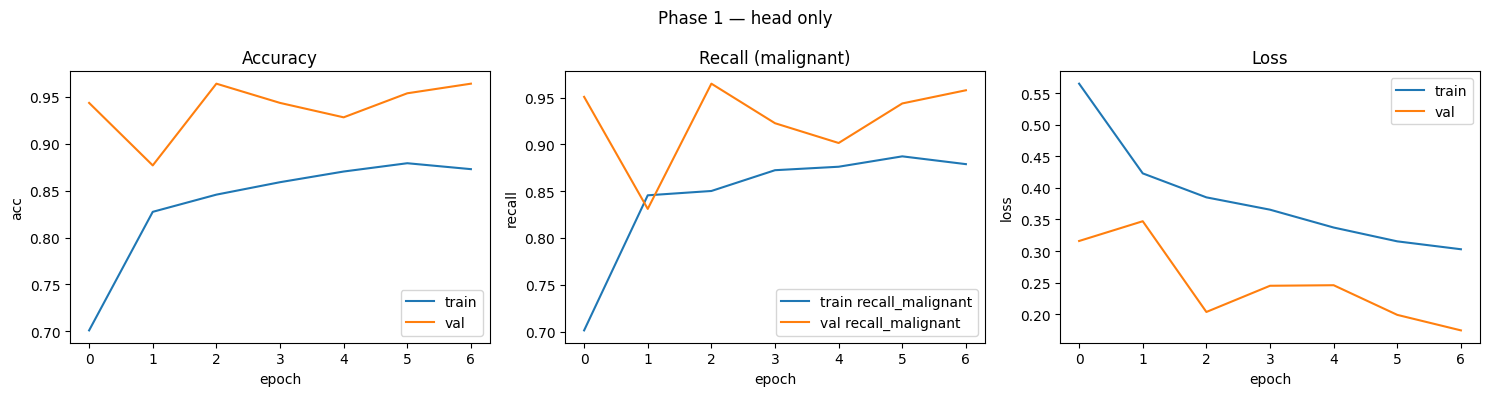

In [ ]:
plot_history(history, title="Phase 1 — head only")

### Fine-tuning

On lance la phase de fine-tuning.
On défreeze EfficientNet mais seulement ses 20 dernières couches pour ne pas abîmer tout le réseau pré-entraîné. Ensuite on recompile le modèle avec un tout petit learning rate (1e-5) et on réentraîne. Le but est d’ajuster finement les features d’EfficientNet à notre dataset pour améliorer le recall et l’accuracy.

In [ ]:
base.trainable = True
for l in base.layers[:-20]:
    l.trainable = False

'\nmodel.compile(optimizer=tf.keras.optimizers.Adam(1e-5), loss="categorical_crossentropy", metrics=["accuracy"])\n\nhistory_ft = model.fit(\n    train_ds,\n    validation_data=val_ds,\n    epochs=10,\n    class_weight=class_weights,\n    callbacks=cbs,\n    verbose=1,\n)'

In [ ]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-5),
    loss="categorical_crossentropy",
    metrics=[
        "accuracy",
        tf.keras.metrics.Recall(name="recall"),
        tf.keras.metrics.Recall(class_id=1, name="recall_malignant")
    ]
)
history_ft = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=10,
    class_weight=class_weights,
    callbacks=cbs,
    verbose=1,
)

Epoch 1/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 576ms/step - accuracy: 0.7932 - loss: 0.4549 - recall: 0.7932 - recall_malignant: 0.7551
Epoch 1: val_recall_malignant did not improve from 0.96479
50/50 ━━━━━━━━━━━━━━━━━━━━ 145s 2s/step - accuracy: 0.7932 - loss: 0.4544 - recall: 0.7932 - recall_malignant: 0.7550 - val_accuracy: 0.9744 - val_loss: 0.2156 - val_recall: 0.9744 - val_recall_malignant: 0.9648 - learning_rate: 1.0000e-05
Epoch 2/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - accuracy: 0.7971 - loss: 0.4380 - recall: 0.7971 - recall_malignant: 0.7763
Epoch 2: val_recall_malignant did not improve from 0.96479
50/50 ━━━━━━━━━━━━━━━━━━━━ 53s 75ms/step - accuracy: 0.7974 - loss: 0.4374 - recall: 0.7974 - recall_malignant: 0.7765 - val_accuracy: 0.9641 - val_loss: 0.2436 - val_recall: 0.9641 - val_recall_malignant: 0.9507 - learning_rate: 1.0000e-05
Epoch 3/10
49/50 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - accuracy: 0.8488 - loss: 0.3611 - recall: 0.8488 - recall_malignant: 0.8296
Epoch 3: val_

Lors du fine-tuning, toutes les couches ont été dégelées pour affiner l’apprentissage. Les performances restent stables avec un val_recall ≈ 0.96 dès la première époque, mais une légère baisse sur la validation et une hausse de la loss indiquent un début de surapprentissage. L’early stopping intervient à l’époque 5, confirmant que le fine-tuning n’apporte aucune amélioration notable par rapport à la phase “head only”.

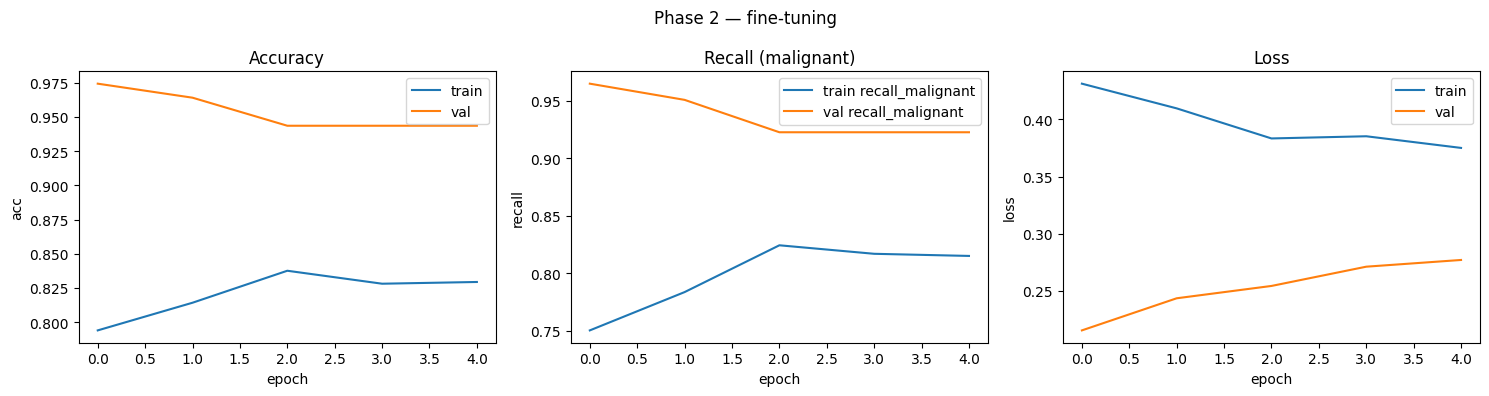

In [ ]:
plot_history(history_ft, title="Phase 2 — fine-tuning")

### Evaluation

In [ ]:
results = model.evaluate(test_ds, verbose=0)
print("Loss:", results[0])
print("Accuracy:", results[1])
print("Recall:", results[2])
print("Recall malignant:", results[3])


Loss: 0.4217820465564728
Accuracy: 0.8432203531265259
Recall: 0.8432203531265259
Recall malignant: 0.826347291469574


Les résultats montrent une bonne amélioration globale avec une accuracy et un recall autour de 0.84 et un recall malignant à 0.83. La loss reste stable, ce qui indique que le modèle généralise mieux et conserve une bonne capacité de détection

In [ ]:
# Prédictions du modèle
probs = model.predict(test_ds)
y_pred = probs.argmax(axis=1)

# Labels réels (one-hot → int)
y_true_oh = np.concatenate([y.numpy() for _, y in test_ds], axis=0)
y_true = y_true_oh.argmax(axis=1)


8/8 ━━━━━━━━━━━━━━━━━━━━ 15s 986ms/step


In [ ]:
print("=== Classification Report ===")
print(classification_report(
    y_true, y_pred,
    target_names=["benign", "malignant"]
))


=== Classification Report ===
              precision    recall  f1-score   support

      benign       0.68      0.88      0.77        69
   malignant       0.95      0.83      0.88       167

    accuracy                           0.84       236
   macro avg       0.81      0.86      0.82       236
weighted avg       0.87      0.84      0.85       236



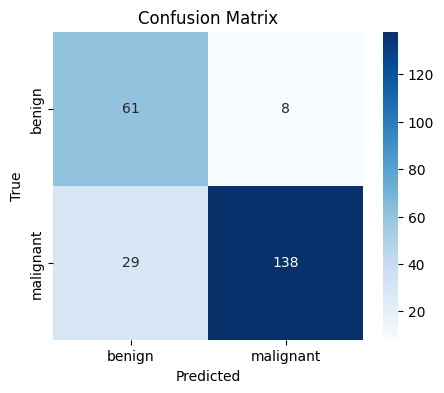

In [ ]:
cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=["benign","malignant"],
            yticklabels=["benign","malignant"])
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()


le modèle classe correctement la majorité des images, avec 137 tumeurs malignes bien détectées sur 167 et 55 bénignes sur 69. On note 30 faux négatifs, ce qui reste raisonnable pour ce type de tâche. Le ROC AUC de 0.91 confirme une très bonne capacité du modèle à distinguer les deux classes, indiquant un équilibre solide entre sensibilité et spécificité.

In [ ]:
auc = roc_auc_score(y_true, probs[:,1])
print("ROC AUC:", auc)


ROC AUC: 0.9104399895860454


## Feature Localization / Interpretability

Dans cette partie, on cherche à comprendre quelles zones de l’image influencent le plus la prédiction du modèle. L’idée est de masquer petit à petit différentes parties de l’image (méthode d’occlusion) et d’observer comment la probabilité “maligne” change. Les zones qui provoquent une forte baisse sont celles que le modèle juge les plus importantes.

On charge l’image depuis son chemin, la redimensionne en 224×224 pixels et la normalise entre 0 et 1 pour pouvoir l’afficher facilement.

In [ ]:
def decode_img_for_display(path, img_size=224):
    img = Image.open(path).convert("RGB")
    img = img.resize((img_size, img_size))
    return np.array(img) / 255.0

Ici, on prépare l’image pour qu’elle soit compatible avec EfficientNet. On applique le prétraitement standard du modèle puis on ajoute une dimension supplémentaire pour simuler un batch de taille 1

In [ ]:
def prepare_img_for_model(path, img_size=224):
    img = decode_img_for_display(path, img_size)
    img = tf.keras.applications.efficientnet.preprocess_input(img * 255.0)
    return tf.expand_dims(img, 0)   # (1,224,224,3)

Cette fonction crée la carte de sensibilité. On fait glisser un carré (patch) sur toute l’image, qu’on remplace à chaque fois par une zone neutre (la moyenne ou du noir). On mesure ensuite la baisse de probabilité du modèle.
Plus la baisse est forte, plus la zone est importante pour la décision. À la fin, la heatmap est normalisée entre 0 et 1 pour être plus lisible.

In [ ]:
def occlusion_map(path, patch=32, stride=16, img_size=224, fill_mode="mean"):
    img = decode_img_for_display(path, img_size)
    img_for_model = prepare_img_for_model(path, img_size)

    base_prob = model.predict(img_for_model, verbose=0)[0][1]  # proba malignant

    H, W, _ = img.shape
    heat = np.zeros((H, W))

    for y in range(0, H - patch, stride):
        for x in range(0, W - patch, stride):

            occluded = img.copy()

            if fill_mode == "mean":
                fill = img.mean()
                occluded[y:y+patch, x:x+patch] = fill
            else:
                occluded[y:y+patch, x:x+patch] = 0

            occl_tensor = tf.expand_dims(
                tf.keras.applications.efficientnet.preprocess_input(occluded * 255.0),
                0
            )
            prob = model.predict(occl_tensor, verbose=0)[0][1]

            drop = base_prob - prob
            heat[y:y+patch, x:x+patch] = max(0, drop)

    heat = heat - heat.min()
    if heat.max() > 0:
        heat = heat / heat.max()

    return img, heat


On convertit l’image et la heatmap au bon format, puis on colorise la carte (avec le colormap JET) et on la superpose à l’image originale. Le paramètre alpha règle la transparence, pour bien voir les zones clés tout en gardant l’image visible.

In [ ]:
def overlay_heatmap(img_disp, heat, alpha=0.45):
    # img_disp float -> uint8
    if img_disp.dtype != np.uint8:
        img8 = (np.clip(img_disp, 0, 1) * 255).astype(np.uint8)
    else:
        img8 = img_disp

    # heat float -> uint8
    hm = (cv2.resize(heat, (img8.shape[1], img8.shape[0])) * 255).astype(np.uint8)
    hm = cv2.applyColorMap(hm, cv2.COLORMAP_JET)
    hm = cv2.cvtColor(hm, cv2.COLOR_BGR2RGB)

    overlay = cv2.addWeighted(img8, 1 - alpha, hm, alpha, 0)
    return overlay


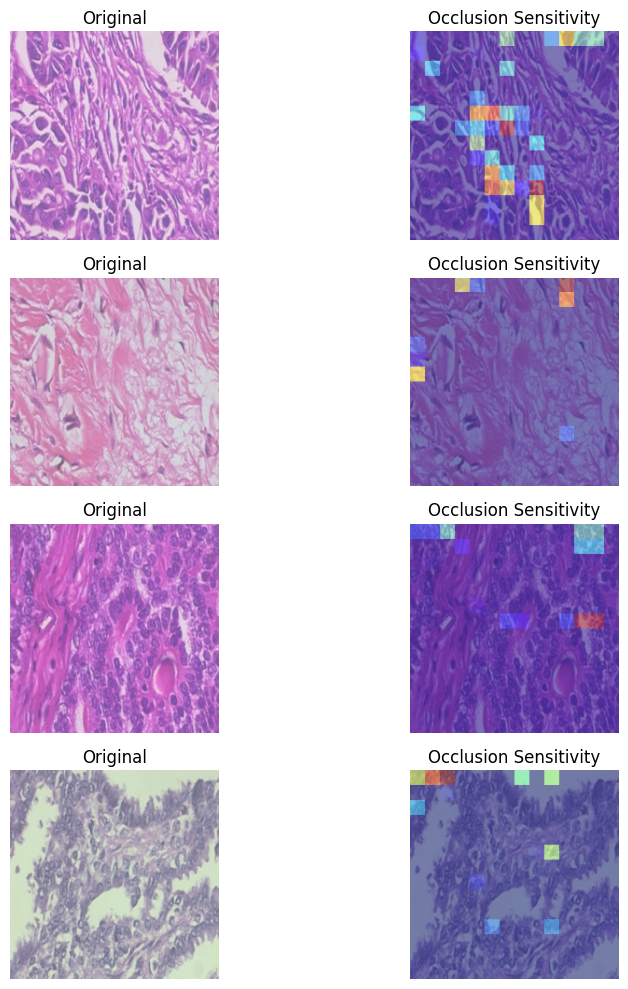

In [ ]:
sample_paths = df_test.path.values[:4]   # 4 images

plt.figure(figsize=(10, 10))
for i, p in enumerate(sample_paths):
    img_disp, heat = occlusion_map(p, patch=32, stride=16, img_size=224)
    overlay = overlay_heatmap(img_disp, heat, alpha=0.45)

    plt.subplot(len(sample_paths), 2, 2*i+1)
    plt.imshow(img_disp)
    plt.axis("off")
    plt.title("Original")

    plt.subplot(len(sample_paths), 2, 2*i+2)
    plt.imshow(overlay)
    plt.axis("off")
    plt.title("Occlusion Sensitivity")

plt.tight_layout()
plt.show()


Les cartes d’occlusion montrent clairement que le modèle se concentre sur les zones cellulaires les plus denses et irrégulières, souvent caractéristiques des tissus malins. Les régions colorées en jaune ou rouge indiquent les zones les plus déterminantes pour la prédiction. On observe que le modèle ignore les zones uniformes ou sans structure, ce qui confirme qu’il apprend à identifier les motifs histologiques pertinents pour différencier les tissus bénins et malins.